# import

In [4]:
import os
import numpy as np
import tifffile as tif
import SimpleITK as sitk
import sys
from scipy import ndimage
from scipy.ndimage import zoom
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from glob import glob
import warnings
import cv2 as cv2
from PIL import Image

# User inputs

In [8]:
image_to_warp = tif.imread('/Users/emilydennis/Desktop/slicedir/A243/A243_XY05.ome.tif')[0]
volume_to_warp = tif.imread('/Users/emilydennis/Desktop/atlasdir/mPRA_SIGMA_annotation-volume.tif')

# define functions

In [178]:
def rotated_imports(full_path_to_atlas,slice_direction):
    if slice_direction == 'coronal':
        atl = np.swapaxes(tif.imread(full_path_to_atlas),0,2)
    elif slice_direction == 'sagittal':
        atl = np.swapaxes(tif.imread(full_path_to_atlas),0,1)
    elif slice_direction == 'axial':
        atl = np.swapaxes(tif.imread(full_path_to_atlas),1,2).T
    else:
        print("OOPS you need to define slice_direction in the User inputs section as either 'coronal','sagittal', or 'axial'")
    return(atl)

In [17]:
def get_triangulation_indices(points):
    """Get indices triples for every triangle
    """
    # Bounding rectangle
    bounding_rect = (*points.min(axis=0), *points.max(axis=0))

    # Triangulate all points
    subdiv = cv2.Subdiv2D(bounding_rect)
    subdiv.insert(list(points))

    # Iterate over all triangles
    for x1, y1, x2, y2, x3, y3 in subdiv.getTriangleList():
        # Get index of all points
        yield [(points==point).all(axis=1).nonzero()[0][0] for point in [(x1,y1), (x2,y2), (x3,y3)]]
    
def crop_to_triangle(img, triangle):
    """Crop image to triangle
    """
    # Get bounding rectangle
    bounding_rect = cv2.boundingRect(triangle)
    print("bounding rec is {}".format(bounding_rect))
    # Crop image to bounding box
    img_cropped = img[bounding_rect[1]:bounding_rect[1] + bounding_rect[3],
                      bounding_rect[0]:bounding_rect[0] + bounding_rect[2]]
    # Move triangle to coordinates in cropped image
    triangle_cropped = [(point[0]-bounding_rect[0], point[1]-bounding_rect[1]) for point in triangle]
    return triangle_cropped, img_cropped

def transform(src_img, src_points, dst_img, dst_points): 
    """Transforms source image to target image, overwriting the target image.
    """
    for indices in get_triangulation_indices(src_points):
        # Get triangles from indices
        src_triangle = src_points[indices]
        dst_triangle = dst_points[indices]

        # Crop to triangle, to make calculations more efficient
        src_triangle_cropped, src_img_cropped = crop_to_triangle(src_img, src_triangle)
        dst_triangle_cropped, dst_img_cropped = crop_to_triangle(dst_img, dst_triangle)

        # Calculate transfrom to warp from old image to new
        transform = cv2.getAffineTransform(np.float32(src_triangle_cropped), np.float32(dst_triangle_cropped))

        # Warp image
        dst_img_warped = cv2.warpAffine(src_img_cropped, transform, (dst_img_cropped.shape[1], dst_img_cropped.shape[0]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

        # Create mask for the triangle we want to transform
        mask = np.zeros(dst_img_cropped.shape, dtype = np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dst_triangle_cropped), (1.0, 1.0, 1.0), 16, 0);

        # Delete all existing pixels at given mask
        dst_img_cropped*=1-mask
        # Add new pixels to masked area
        dst_img_cropped+=dst_img_warped*mask

In [19]:
src_points = np.array([(0,0),(0,2000),(2500,2000)])
dst_points = np.array([(1000,1000),(0,3000),(2000,3000)])
warped_image = image_to_warp.copy()

In [23]:
src_points = np.array([(1000, 1000), (38, 65), (47, 115), (66, 147), (107, 166), (147, 150), (172, 118), (177, 75), (173, 26), (63, 19), (89, 30), (128, 34), (152, 27), (75, 46), (142, 46), (109, 48), (95, 96), (107, 91), (120, 97), (84, 123), (106, 117), (132, 121), (97, 137), (107, 139), (120, 135)])
dst_points = np.array([(2, 16), (0, 60), (2, 143), (47, 181), (121, 178), (208, 181), (244, 133), (241, 87), (241, 18), (41, 15), (73, 20), (174, 16), (218, 16), (56, 23), (191, 23), (120, 48), (94, 128), (120, 122), (150, 124), (83, 174), (122, 164), (159, 173), (110, 174), (121, 174), (137, 175)])
transform(image_to_warp,src_points,warped_image,dst_points)

bounding rec is (63, 19, 27, 28)
bounding rec is (41, 15, 33, 9)
bounding rec is (38, 19, 38, 47)
bounding rec is (0, 15, 57, 46)
bounding rec is (107, 150, 894, 851)
bounding rec is (2, 16, 207, 166)
bounding rec is (147, 118, 854, 883)
bounding rec is (2, 16, 243, 166)
bounding rec is (38, 65, 58, 51)
bounding rec is (0, 60, 95, 84)
bounding rec is (84, 96, 23, 28)
bounding rec is (83, 128, 40, 47)
bounding rec is (95, 91, 13, 27)
bounding rec is (94, 122, 29, 43)
bounding rec is (47, 115, 38, 33)
bounding rec is (2, 143, 82, 39)
bounding rec is (66, 137, 42, 30)
bounding rec is (47, 174, 75, 8)
bounding rec is (47, 96, 49, 28)
bounding rec is (2, 128, 93, 47)
bounding rec is (107, 135, 41, 32)
bounding rec is (121, 175, 88, 7)
bounding rec is (75, 46, 35, 46)
bounding rec is (56, 23, 65, 100)
bounding rec is (107, 48, 14, 50)
bounding rec is (120, 48, 31, 77)
bounding rec is (172, 75, 829, 926)
bounding rec is (2, 16, 243, 118)
bounding rec is (132, 118, 41, 33)
bounding rec is (159

AttributeError: 'cv2.Subdiv2D' object has no attribute 'get_TriangleList'

In [45]:
# Bounding rectangle
bounding_rect = (*src_points.min(axis=0), *src_points.max(axis=0))

ls('/Users/emilydennis/Desktop/GitHub/FaceChanger/')

# Triangulate all points
subdiv = cv2.Subdiv2D(bounding_rect)
subdiv.insert(list(src_points))

# Iterate over all triangles
for x1, y1, x2, y2, x3, y3 in subdiv.getTriangleList():
    print(x1,x2,y2,x3,y3)
    # Get index of all points
    #yield [(points==point).all(axis=1).nonzero()[0][0] for point in [(x1,y1), (x2,y2), (x3,y3)]]


75.0 63.0 19.0 89.0 30.0
63.0 75.0 46.0 38.0 65.0
147.0 1000.0 1000.0 107.0 166.0
1000.0 147.0 150.0 172.0 118.0
47.0 38.0 65.0 95.0 96.0
95.0 106.0 117.0 84.0 123.0
106.0 95.0 96.0 107.0 91.0
66.0 47.0 115.0 84.0 123.0
107.0 66.0 147.0 97.0 137.0
47.0 95.0 96.0 84.0 123.0
147.0 107.0 166.0 120.0 135.0
109.0 107.0 91.0 75.0 46.0
107.0 109.0 48.0 120.0 97.0
1000.0 172.0 118.0 177.0 75.0
172.0 147.0 150.0 132.0 121.0
95.0 75.0 46.0 107.0 91.0
75.0 95.0 96.0 38.0 65.0
1000.0 177.0 75.0 173.0 26.0
177.0 172.0 118.0 120.0 97.0
109.0 89.0 30.0 128.0 34.0
89.0 109.0 48.0 75.0 46.0
173.0 177.0 75.0 142.0 46.0
63.0 173.0 26.0 152.0 27.0
109.0 128.0 34.0 142.0 46.0
89.0 63.0 19.0 152.0 27.0
89.0 152.0 27.0 128.0 34.0
142.0 152.0 27.0 173.0 26.0
152.0 142.0 46.0 128.0 34.0
177.0 120.0 97.0 142.0 46.0
109.0 142.0 46.0 120.0 97.0
106.0 107.0 91.0 120.0 97.0
107.0 106.0 117.0 120.0 135.0
106.0 107.0 139.0 97.0 137.0
120.0 172.0 118.0 132.0 121.0
97.0 66.0 147.0 84.0 123.0
84.0 106.0 117.0 97.0 137.0

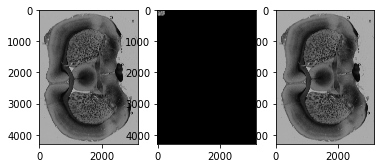

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.imshow(image_to_warp,'gray')
ax2.imshow(image_to_warp-warped_image,'gray')
ax3.imshow(image_to_warp,'gray')